In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Load data

sessions_df = pd.read_csv('D:/Education/Syracuse University/Projects/iHoop Insights/injury_history(player_sessions).csv', encoding='ISO-8859-1')
muscle_df = pd.read_csv('D:/Education/Syracuse University/Projects/iHoop Insights/injury_history(muscle_imbalance_data).csv', encoding='ISO-8859-1')
injury_df = pd.read_csv('D:/Education/Syracuse University/Projects/iHoop Insights/injury_history(injury_history).csv', encoding='ISO-8859-1')


In [2]:
# Function to clean column names
def clean_column_names(df):
    df.columns = df.columns.str.replace('[^A-Za-z0-9]+', '_', regex=True).str.strip('_')
    return df

# Apply the function to each DataFrame
sessions_df = clean_column_names(sessions_df)
muscle_df = clean_column_names(muscle_df)
injury_df = clean_column_names(injury_df)

In [3]:
sessions_df.head()

,Name,Player_ID,Group_Id,Group_name,League_ID,Session_ID,Session_Date,Position,Distance_mi,Distance_min_mi,...,Heart_Rate_min_bpm,Heart_Rate_max_bpm,Human_Core_Temperature_F,Human_Core_Temperature_max_F,TRIMP,Heart_Rate_Recoveries,Jump_Height_max_ft,Changes_of_Orientation,Exertions,Disk_Usage
0,Anthony Lopez,112,212,Group 1,301,1001,1/1/2023,Center,4.58,0.12,...,74,198,99.47,101.24,261,5,2.31,229,307,58.56
1,Anthony Lopez,112,212,Group 1,301,1002,1/3/2023,Center,1.18,0.11,...,62,179,99.56,99.33,270,6,2.44,427,180,44.93
2,Anthony Lopez,112,212,Group 1,301,1003,1/4/2023,Center,5.59,0.14,...,78,172,100.06,102.31,149,4,3.04,383,440,15.32
3,Anthony Lopez,112,212,Group 1,301,1004,1/6/2023,Center,3.22,0.09,...,64,186,100.45,101.10,180,10,3.17,462,450,21.46
4,Anthony Lopez,112,212,Group 1,301,1005,1/7/2023,Center,2.19,0.10,...,62,146,98.73,100.91,152,4,1.28,118,416,20.51


In [4]:
muscle_df.head()

,Player_ID,Session_ID,Player_Name,Date_Recorded,Hamstring_To_Quad_Ratio,Quad_Imbalance_Percent,HamstringImbalance_Percent,Calf_Imbalance_Percent,Groin_Imbalance_Percent
0,112,101,Anthony Lopez,1/1/2023,0.808741,-10.149294,-8.208145,-10.176416,-10.258755
1,112,102,Anthony Lopez,2/1/2023,0.814355,-10.105784,-8.229693,-10.106144,-10.063777
2,112,103,Anthony Lopez,3/1/2023,0.887331,-10.027546,-8.897757,-10.257486,-9.990676
3,112,104,Anthony Lopez,4/1/2023,0.929176,-10.137407,-9.419432,-10.220899,-10.179258
4,112,105,Anthony Lopez,5/1/2023,0.866234,-9.958386,-8.626291,-10.412659,-10.208611


In [5]:
injury_df.head()

,Player_ID,Name,Group_Id,Injury_Type,Body_Part,Side,Injury_Date,Severity,Recovery_Time_days,Additional_Notes
0,101,Jordan Matthews,201,Muscle Strain,Quadriceps,Right,12/5/2023,Grade 2,51,Grade 2 quadriceps strain with partial tearing...
1,101,Jordan Matthews,201,Tendonitis,Wrist,Left,10/25/2023,NaN,11,De Quervain's tenosynovitis. Swelling and pain...
2,101,Jordan Matthews,201,Tendonitis,Shoulder,Right,7/22/2023,NaN,12,Rotator cuff tendonitis due to overuse. Anti-i...
3,103,Malik Robinson,203,Strain,Groin,Right,6/28/2023,Grade 1,20,"Grade 1 groin strain, characterized by mild ov..."
4,103,Malik Robinson,203,Fracture,Wrist,Left,2/14/2023,NaN,68,Distal radius fracture. Cast applied. Recovery...


In [7]:
sessions_df['Session_Date'] = pd.to_datetime(sessions_df['Session_Date'])
sessions_df['join_key'] = (sessions_df['Player_ID'].astype(str) + '_' + 
                          sessions_df['Session_Date'].dt.month.astype(str) + '_' +
                          sessions_df['Session_Date'].dt.year.astype(str))

muscle_df['Date_Recorded'] = pd.to_datetime(muscle_df['Date_Recorded'])
muscle_df['join_key'] = (muscle_df['Player_ID'].astype(str) + '_' + 
                        muscle_df['Date_Recorded'].dt.month.astype(str) + '_' +
                        muscle_df['Date_Recorded'].dt.year.astype(str))


sessions_muscle_merged = pd.merge(
    sessions_df,
    muscle_df,
    on='join_key',
    how='left',
    suffixes=('', '_muscle')
)

columns_to_drop = ['Player_ID_muscle', 'Player_Name','Session_ID_muscle']
sessions_muscle_merged = sessions_muscle_merged.drop(columns=columns_to_drop)

In [8]:
injury_df['Injury_Date'] = pd.to_datetime(injury_df['Injury_Date'])
injury_df['join_key'] = (injury_df['Player_ID'].astype(str) + '_' + 
                        injury_df['Injury_Date'].dt.month.astype(str) + '_' +
                        injury_df['Injury_Date'].dt.year.astype(str))

final_merged_df = pd.merge(
    sessions_muscle_merged,
    injury_df,
    on=['join_key'],
    how='left',
    suffixes=('', '_injury')
)

columns_to_drop = ['Player_ID_injury', 'Name_injury', 'Group_Id_injury']
final_merged_df = final_merged_df.drop(columns=columns_to_drop)

In [9]:
final_merged_df.head()

,Name,Player_ID,Group_Id,Group_name,League_ID,Session_ID,Session_Date,Position,Distance_mi,Distance_min_mi,...,HamstringImbalance_Percent,Calf_Imbalance_Percent,Groin_Imbalance_Percent,Injury_Type,Body_Part,Side,Injury_Date,Severity,Recovery_Time_days,Additional_Notes
0,Anthony Lopez,112,212,Group 1,301,1001,2023-01-01,Center,4.58,0.12,...,-8.208145,-10.176416,-10.258755,Strain,Knee,Left,2023-01-26,Grade 1,28.0,Strain of the posterior cruciate ligament (PCL...
1,Anthony Lopez,112,212,Group 1,301,1002,2023-01-03,Center,1.18,0.11,...,-8.208145,-10.176416,-10.258755,Strain,Knee,Left,2023-01-26,Grade 1,28.0,Strain of the posterior cruciate ligament (PCL...
2,Anthony Lopez,112,212,Group 1,301,1003,2023-01-04,Center,5.59,0.14,...,-8.208145,-10.176416,-10.258755,Strain,Knee,Left,2023-01-26,Grade 1,28.0,Strain of the posterior cruciate ligament (PCL...
3,Anthony Lopez,112,212,Group 1,301,1004,2023-01-06,Center,3.22,0.09,...,-8.208145,-10.176416,-10.258755,Strain,Knee,Left,2023-01-26,Grade 1,28.0,Strain of the posterior cruciate ligament (PCL...
4,Anthony Lopez,112,212,Group 1,301,1005,2023-01-07,Center,2.19,0.10,...,-8.208145,-10.176416,-10.258755,Strain,Knee,Left,2023-01-26,Grade 1,28.0,Strain of the posterior cruciate ligament (PCL...


In [10]:
final_merged_df.dtypes

Name                                      object
Player_ID                                  int64
Group_Id                                   int64
Group_name                                object
League_ID                                  int64
Session_ID                                 int64
Session_Date                      datetime64[ns]
Position                                  object
Distance_mi                              float64
Distance_min_mi                          float64
Duration_s                                 int64
Steps                                      int64
Speed_of_max                             float64
Speed_max_mph                            float64
Speed_mph                                float64
Time_s                                     int64
Accumulated_Acceleration_Load              int64
Anaerobic_Activity_distance_mi           float64
Jump_Load_J                                int64
Heart_Rate_bpm                             int64
Heart_Rate_min_bpm  

In [18]:
# Basic dataset information
print("Dataset Overview:")
print(f"Total number of records: {len(final_merged_df)}")
print(f"Number of unique players: {final_merged_df['Player_ID'].nunique()}")
print(f"Date range: from {final_merged_df['Session_Date'].min()} to {final_merged_df['Session_Date'].max()}")

Dataset Overview:
Total number of records: 2604
Number of unique players: 14
Date range: from 2023-01-01 00:00:00 to 2023-12-30 00:00:00


In [19]:
# Create injury indicator
final_merged_df['had_injury'] = final_merged_df['Injury_Type'].notna().astype(int)

# Injury statistics
print("\nInjury Statistics:")
total_injuries = final_merged_df['had_injury'].sum()
injury_rate = (total_injuries / len(final_merged_df)) * 100
print(f"Total number of injuries: {total_injuries}")
print(f"Injury rate: {injury_rate:.2f}%")


Injury Statistics:
Total number of injuries: 226
Injury rate: 8.68%


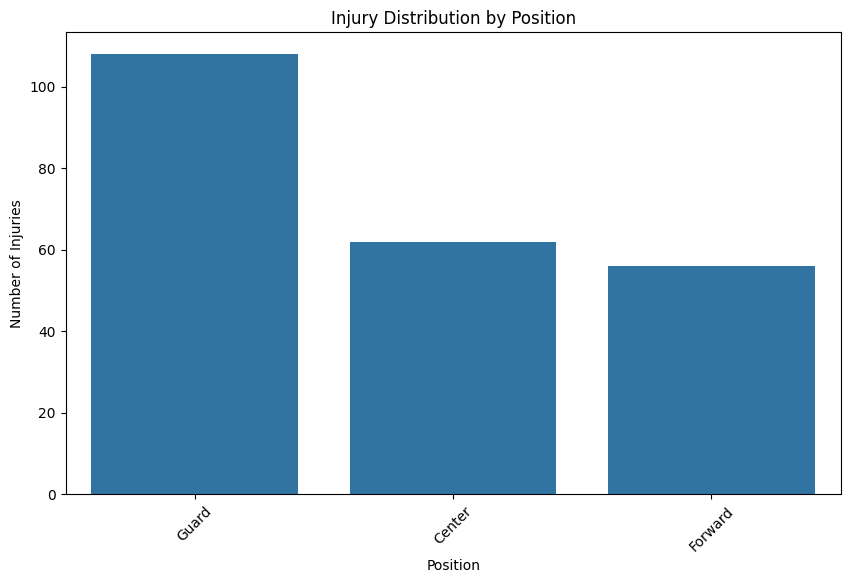

In [20]:
# Plot injury distribution by position
plt.figure(figsize=(10, 6))
injury_by_position = final_merged_df[final_merged_df['had_injury'] == 1]['Position'].value_counts()
sns.barplot(x=injury_by_position.index, y=injury_by_position.values)
plt.title('Injury Distribution by Position')
plt.xticks(rotation=45)
plt.ylabel('Number of Injuries')
plt.show()

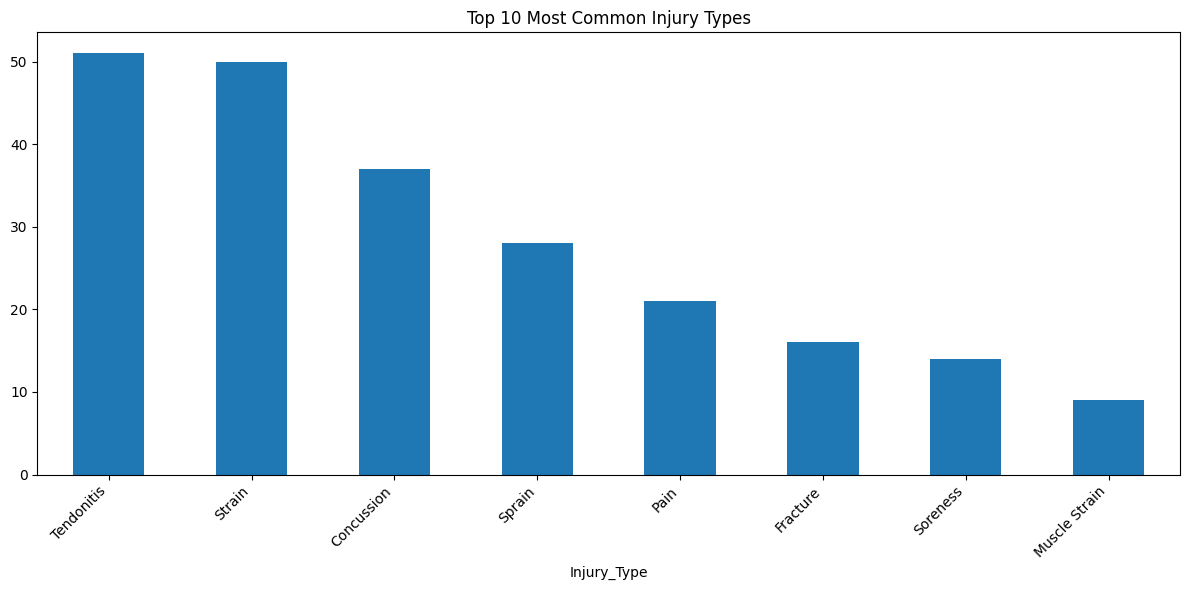

In [21]:
# Injury types distribution
plt.figure(figsize=(12, 6))
final_merged_df['Injury_Type'].dropna().value_counts().head(10).plot(kind='bar')
plt.title('Top 10 Most Common Injury Types')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

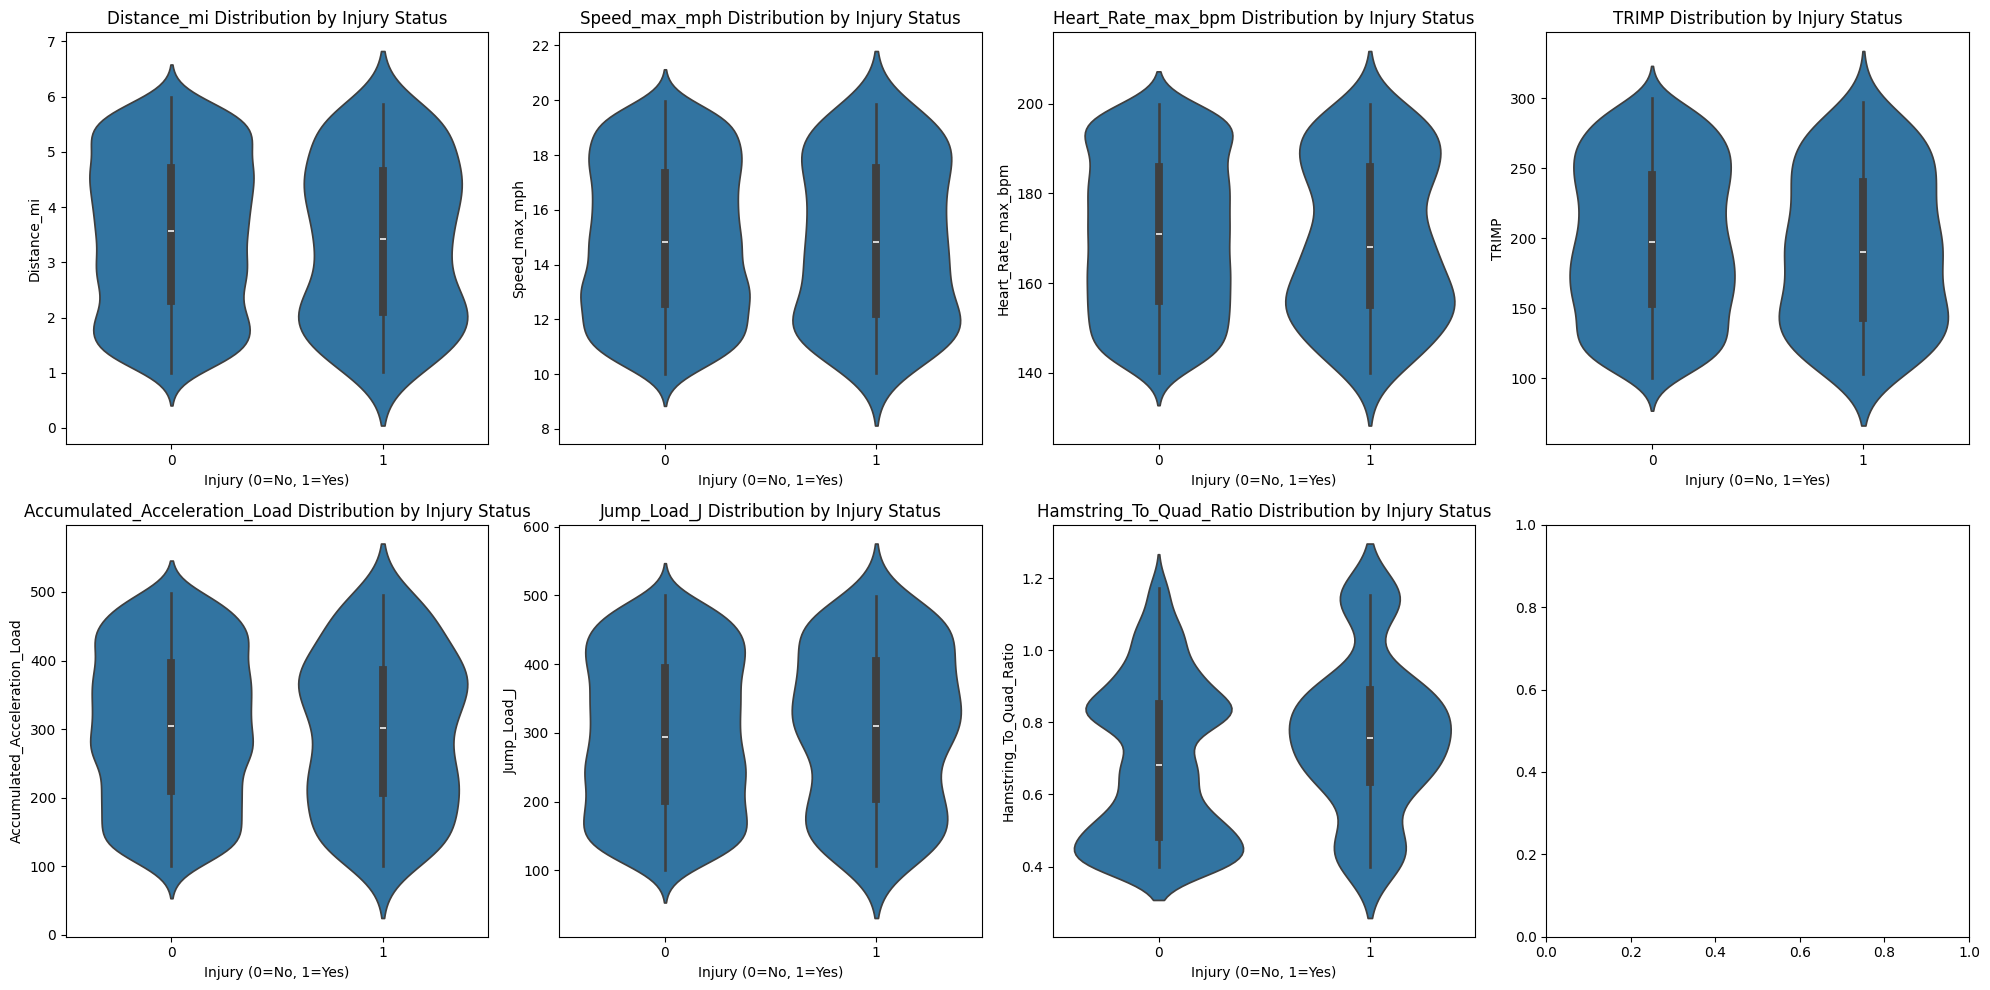

In [22]:
# Analyze key metrics distribution for injured vs non-injured players
metrics_to_analyze = [
    'Distance_mi', 'Speed_max_mph', 'Heart_Rate_max_bpm',
    'TRIMP', 'Accumulated_Acceleration_Load', 'Jump_Load_J',
    'Hamstring_To_Quad_Ratio'
]

# Create violin plots for key metrics
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.ravel()

for idx, metric in enumerate(metrics_to_analyze):
    if metric in final_merged_df.columns:
        sns.violinplot(data=final_merged_df, x='had_injury', y=metric, ax=axes[idx])
        axes[idx].set_title(f'{metric} Distribution by Injury Status')
        axes[idx].set_xlabel('Injury (0=No, 1=Yes)')

plt.tight_layout()
plt.show()

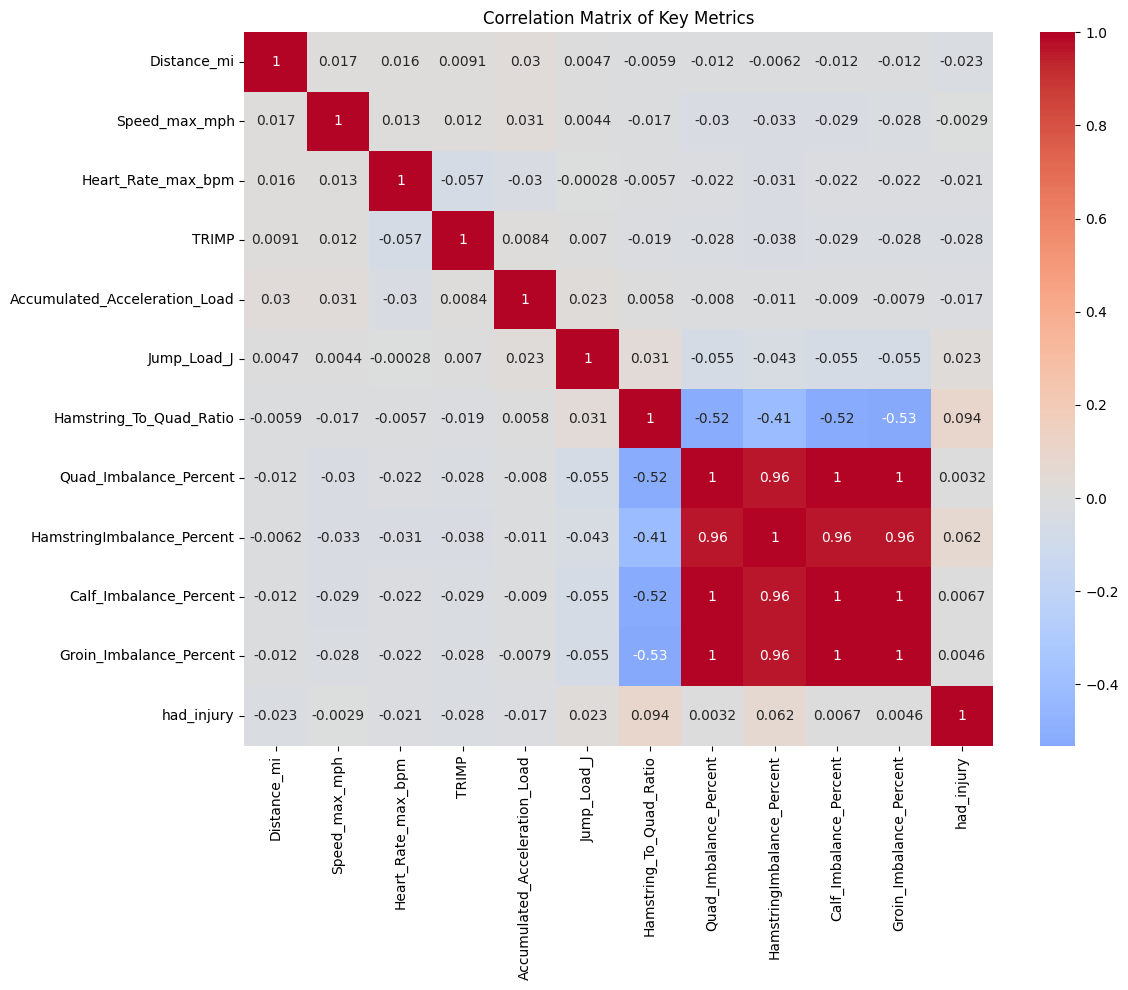

In [23]:
# Correlation analysis
correlation_metrics = metrics_to_analyze + [
    'Quad_Imbalance_Percent', 'HamstringImbalance_Percent',
    'Calf_Imbalance_Percent', 'Groin_Imbalance_Percent'
]

correlation_df = final_merged_df[correlation_metrics].copy()
correlation_df['had_injury'] = final_merged_df['had_injury']

# Plot correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_df.corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Key Metrics')
plt.tight_layout()
plt.show()

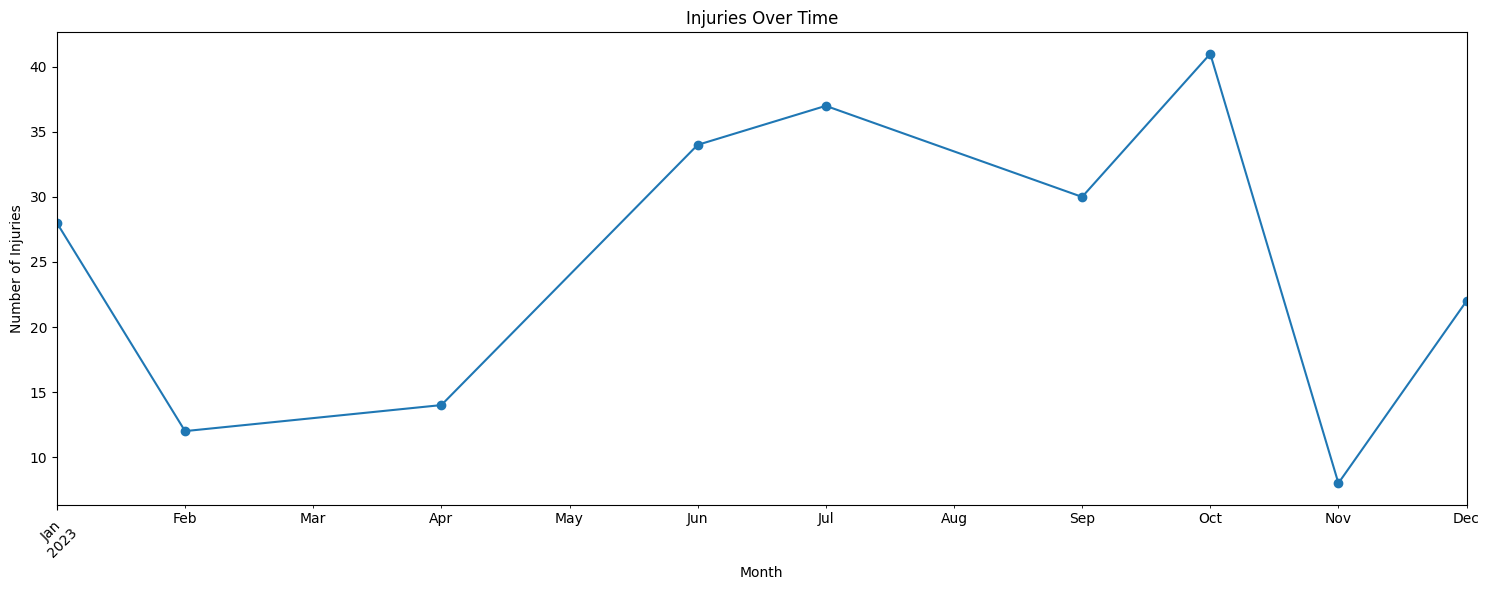

In [24]:
# Temporal analysis
plt.figure(figsize=(15, 6))
injury_over_time = final_merged_df[final_merged_df['had_injury'] == 1].groupby(
    final_merged_df['Session_Date'].dt.to_period('M')
).size()
injury_over_time.plot(kind='line', marker='o')
plt.title('Injuries Over Time')
plt.xlabel('Month')
plt.ylabel('Number of Injuries')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [26]:
# Statistical significance testing
print("\nStatistical Tests (Injured vs Non-injured):")
for metric in metrics_to_analyze:
    if metric in final_merged_df.columns:
        injured = final_merged_df[final_merged_df['had_injury'] == 1][metric].dropna()
        non_injured = final_merged_df[final_merged_df['had_injury'] == 0][metric].dropna()
        stat, p_value = stats.ttest_ind(injured, non_injured)
        print(f"{metric}: p-value = {p_value:.4f}")


Statistical Tests (Injured vs Non-injured):
Distance_mi: p-value = 0.2352
Speed_max_mph: p-value = 0.8834
Heart_Rate_max_bpm: p-value = 0.2864
TRIMP: p-value = 0.1590
Accumulated_Acceleration_Load: p-value = 0.3802
Jump_Load_J: p-value = 0.2334
Hamstring_To_Quad_Ratio: p-value = 0.0000


Model Performance Metrics:

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.80      0.89       476
           1       0.32      0.98      0.48        45

    accuracy                           0.82       521
   macro avg       0.66      0.89      0.69       521
weighted avg       0.94      0.82      0.85       521


ROC AUC Score: 0.9364612511671335

Cross-validation ROC AUC scores: [0.96694295 0.94736842 0.95969056 0.95026937 0.95985111]
Mean CV Score: 0.9568244832449959
CV Score STD: 0.00710133474895156

Feature Importance:
                         feature  importance
8         Quad_Imbalance_Percent    0.356789
9         Calf_Imbalance_Percent    0.282587
6        Hamstring_To_Quad_Ratio    0.216864
7                       Position    0.056375
3                          TRIMP    0.025015
2             Heart_Rate_max_bpm    0.020412
0                    Distance_mi    0.016484
5                    Jump_Load_J    0.013179
4 

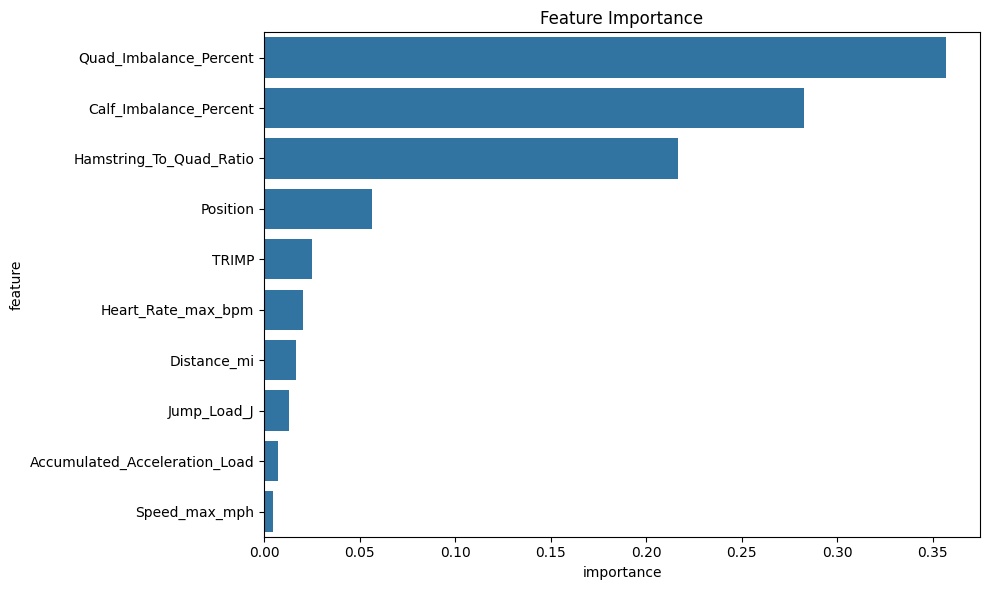

['feature_scaler.joblib']

In [31]:
# Import additional libraries
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE
import numpy as np
import pandas as pd

# Select features based on EDA insights
selected_features = [
    'Distance_mi', 'Speed_max_mph', 'Heart_Rate_max_bpm',
    'TRIMP', 'Accumulated_Acceleration_Load', 'Jump_Load_J',
    'Hamstring_To_Quad_Ratio',  # Most significant feature
    'Position',  # Important categorical feature
    # Choose only one from each highly correlated group
    'Quad_Imbalance_Percent',
    'Calf_Imbalance_Percent'
]

# Prepare the dataset
X = final_merged_df[selected_features].copy()
y = final_merged_df['had_injury']

# Handle categorical variables
le = LabelEncoder()
X['Position'] = le.fit_transform(X['Position'])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

# Initialize model with balanced parameters
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=5,  # Reduced to prevent overfitting
    min_samples_split=5,
    min_samples_leaf=2,
    class_weight='balanced',
    random_state=42
)

# Train model
rf_model.fit(X_train_balanced, y_train_balanced)

# Make predictions
y_pred = rf_model.predict(X_test_scaled)
y_pred_proba = rf_model.predict_proba(X_test_scaled)[:, 1]

# Evaluate model
print("Model Performance Metrics:")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nROC AUC Score:", roc_auc_score(y_test, y_pred_proba))

# Cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(rf_model, X_train_balanced, y_train_balanced, cv=cv, scoring='roc_auc')
print("\nCross-validation ROC AUC scores:", cv_scores)
print("Mean CV Score:", cv_scores.mean())
print("CV Score STD:", cv_scores.std())

# Feature importance
feature_importance = pd.DataFrame({
    'feature': selected_features,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

# Save model and scaler for later use
import joblib
joblib.dump(rf_model, 'injury_prediction_model.joblib')
joblib.dump(scaler, 'feature_scaler.joblib')

Model Performance Metrics:

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.84      0.92       476
           1       0.38      1.00      0.55        45

    accuracy                           0.86       521
   macro avg       0.69      0.92      0.73       521
weighted avg       0.95      0.86      0.88       521


ROC AUC Score: 0.972829131652661

Cross-validation ROC AUC scores: [0.9782254  0.97939098 0.991271   0.98307889 0.98316289]
Mean CV Score: 0.9830258319075249
CV Score STD: 0.004566415252876996

Feature Importance:
                   feature  importance
0   Quad_Imbalance_Percent    0.399662
1   Calf_Imbalance_Percent    0.307856
2  Hamstring_To_Quad_Ratio    0.240975
3                 Position    0.035364
4                    TRIMP    0.016143


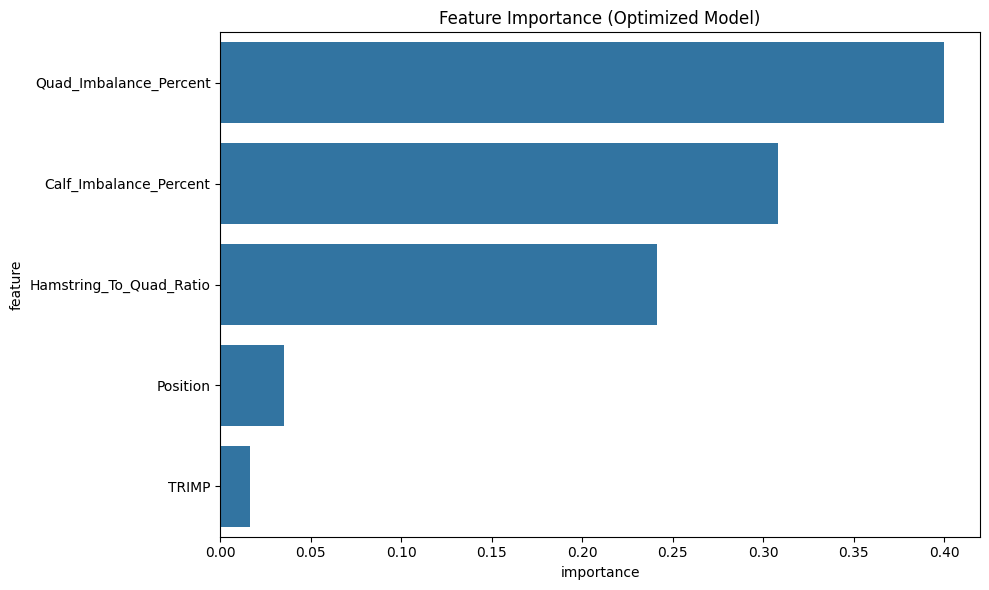

['label_encoder.joblib']

In [33]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
from imblearn.combine import SMOTETomek
import matplotlib.pyplot as plt
import seaborn as sns

# Select features based on importance
selected_features = [
    'Quad_Imbalance_Percent',
    'Calf_Imbalance_Percent',
    'Hamstring_To_Quad_Ratio',
    'Position',
    'TRIMP'
]

# Prepare the dataset
X = final_merged_df[selected_features].copy()
y = final_merged_df['had_injury']

# Encode Position before splitting
le = LabelEncoder()
X['Position'] = le.fit_transform(X['Position'])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply SMOTETomek for balanced sampling
smote_tomek = SMOTETomek(random_state=42)
X_train_balanced, y_train_balanced = smote_tomek.fit_resample(X_train_scaled, y_train)

# Initialize and train the model
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=5,
    min_samples_split=3,
    min_samples_leaf=2,
    class_weight='balanced',
    random_state=42
)

# Train the model
rf_model.fit(X_train_balanced, y_train_balanced)

# Make predictions
y_pred = rf_model.predict(X_test_scaled)
y_pred_proba = rf_model.predict_proba(X_test_scaled)[:, 1]

# Print performance metrics
print("Model Performance Metrics:")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nROC AUC Score:", roc_auc_score(y_test, y_pred_proba))

# Cross-validation scores
cv_scores = cross_val_score(rf_model, X_train_balanced, y_train_balanced, 
                           cv=5, scoring='roc_auc')
print("\nCross-validation ROC AUC scores:", cv_scores)
print("Mean CV Score:", cv_scores.mean())
print("CV Score STD:", cv_scores.std())

# Feature importance
feature_importance = pd.DataFrame({
    'feature': selected_features,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importance (Optimized Model)')
plt.tight_layout()
plt.show()

# Save the model and preprocessing objects
import joblib
joblib.dump(rf_model, 'injury_model.joblib')
joblib.dump(scaler, 'scaler.joblib')
joblib.dump(le, 'label_encoder.joblib')


Feature Importance (Before Calibration):
                   feature  importance
0   Quad_Imbalance_Percent    0.404825
1   Calf_Imbalance_Percent    0.287817
2  Hamstring_To_Quad_Ratio    0.270165
3                 Position    0.020114
4                    TRIMP    0.017080


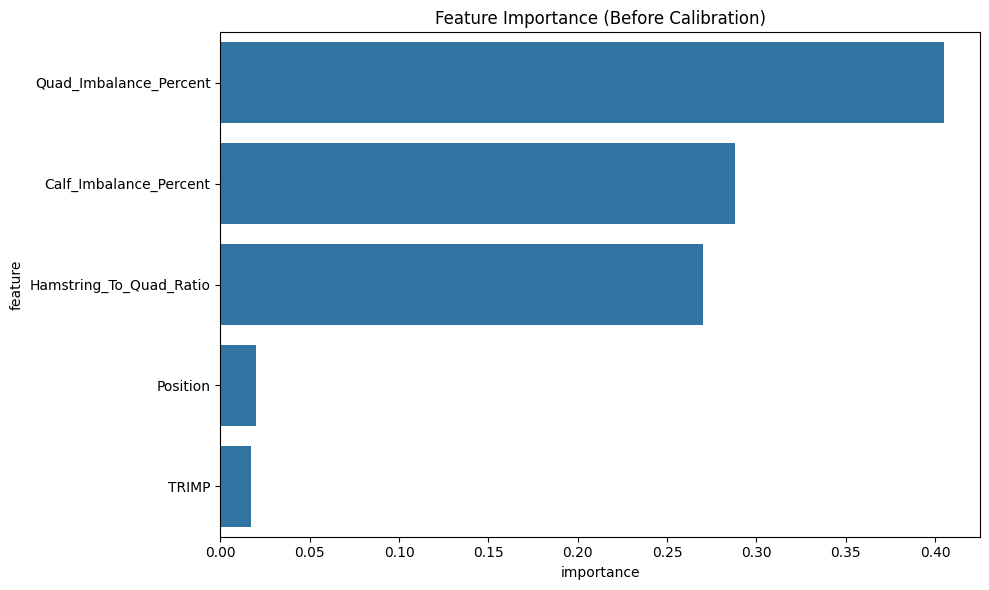


Optimal threshold: 0.514

Model Performance Metrics:

Classification Report (with optimal threshold):
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       595
           1       0.75      0.75      0.75        56

    accuracy                           0.96       651
   macro avg       0.86      0.86      0.86       651
weighted avg       0.96      0.96      0.96       651


ROC AUC Score: 0.9680972388955582


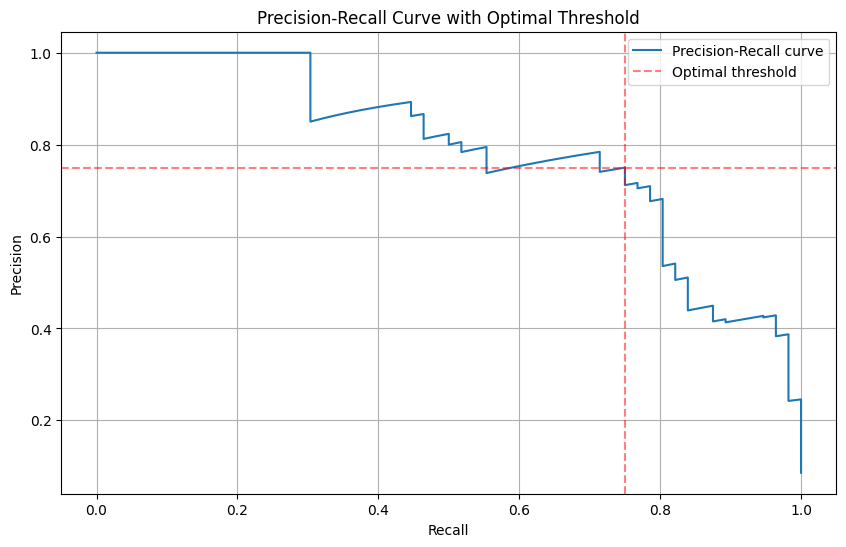


Risk Level Distribution:
Risk_Level
Very Low     519
Low           64
Moderate      19
High          16
Very High     33
Name: count, dtype: int64


['optimal_threshold.joblib']

In [35]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve
from sklearn.calibration import CalibratedClassifierCV
from imblearn.combine import SMOTETomek
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Select features
selected_features = [
    'Quad_Imbalance_Percent',
    'Calf_Imbalance_Percent',
    'Hamstring_To_Quad_Ratio',
    'Position',
    'TRIMP'
]

# Prepare dataset
X = final_merged_df[selected_features].copy()
y = final_merged_df['had_injury']

# Encode Position
le = LabelEncoder()
X['Position'] = le.fit_transform(X['Position'])

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply SMOTE-Tomek
smote_tomek = SMOTETomek(sampling_strategy=0.3, random_state=42)
X_train_balanced, y_train_balanced = smote_tomek.fit_resample(X_train_scaled, y_train)

# Train a regular RandomForest first for feature importance
rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=4,
    min_samples_split=4,
    min_samples_leaf=3,
    class_weight={0: 1, 1: 2},
    random_state=42
)

# Fit the regular model
rf_model.fit(X_train_balanced, y_train_balanced)

# Get and display feature importance before calibration
feature_importance = pd.DataFrame({
    'feature': selected_features,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nFeature Importance (Before Calibration):")
print(feature_importance)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importance (Before Calibration)')
plt.tight_layout()
plt.show()

# Now train the calibrated model
calibrated_model = CalibratedClassifierCV(
    RandomForestClassifier(
        n_estimators=300,
        max_depth=4,
        min_samples_split=4,
        min_samples_leaf=3,
        class_weight={0: 1, 1: 2},
        random_state=42
    ),
    cv=5,
    method='sigmoid'
)

# Fit the calibrated model
calibrated_model.fit(X_train_balanced, y_train_balanced)

# Get predictions
y_pred_proba = calibrated_model.predict_proba(X_test_scaled)[:, 1]

# Find optimal threshold
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]

print(f"\nOptimal threshold: {optimal_threshold:.3f}")

# Make predictions with optimal threshold
y_pred = (y_pred_proba >= optimal_threshold).astype(int)

# Print performance metrics
print("\nModel Performance Metrics:")
print("\nClassification Report (with optimal threshold):")
print(classification_report(y_test, y_pred))
print("\nROC AUC Score:", roc_auc_score(y_test, y_pred_proba))

# Plot precision-recall curve
plt.figure(figsize=(10, 6))
plt.plot(recalls, precisions, label='Precision-Recall curve')
plt.axvline(recalls[optimal_idx], color='r', linestyle='--', alpha=0.5, label='Optimal threshold')
plt.axhline(precisions[optimal_idx], color='r', linestyle='--', alpha=0.5)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve with Optimal Threshold')
plt.legend()
plt.grid(True)
plt.show()

# Calculate risk scores
risk_scores = pd.DataFrame({
    'Actual': y_test,
    'Predicted_Probability': y_pred_proba,
    'High_Risk': y_pred
})

# Add risk levels
risk_scores['Risk_Level'] = pd.cut(
    risk_scores['Predicted_Probability'],
    bins=[0, 0.2, 0.4, 0.6, 0.8, 1.0],
    labels=['Very Low', 'Low', 'Moderate', 'High', 'Very High']
)

print("\nRisk Level Distribution:")
print(risk_scores['Risk_Level'].value_counts().sort_index())

# Save models and preprocessing objects
joblib.dump(calibrated_model, 'calibrated_injury_model.joblib')
joblib.dump(scaler, 'scaler.joblib')
joblib.dump(le, 'label_encoder.joblib')
joblib.dump(optimal_threshold, 'optimal_threshold.joblib')


Top 20 Players at Highest Risk:
                  Name Position  Risk_Score Risk_Level  Hamstring_To_Quad_Ratio  Quad_Imbalance  Calf_Imbalance
1648    Malik Robinson    Guard    0.995734  Very High                 0.755814       14.824414       14.503257
9        Anthony Lopez   Center    0.984551  Very High                 0.808741      -10.149294      -10.176416
216   Brandon Mitchell    Guard    0.958997  Very High                 1.153350        3.715052        3.918576
480     Cameron Howard   Center    0.949337  Very High                 0.911572        6.646572        7.030502
2187      Noah Bradley    Guard    0.884326  Very High                 0.447263       -3.503481       -3.453449
1186    Julian Simmons  Forward    0.792855       High                 0.633234       -1.674534       -2.119009
2090  Miles Richardson   Center    0.654226       High                 0.725252        6.624618        6.412320
1100   Jordan Matthews  Forward    0.570324   Moderate                 

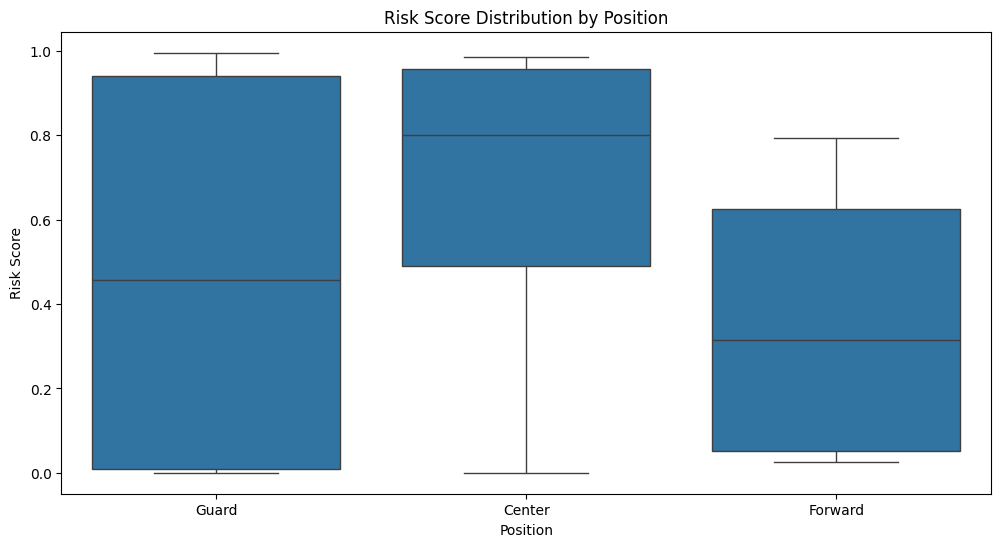

<Figure size 1200x600 with 0 Axes>

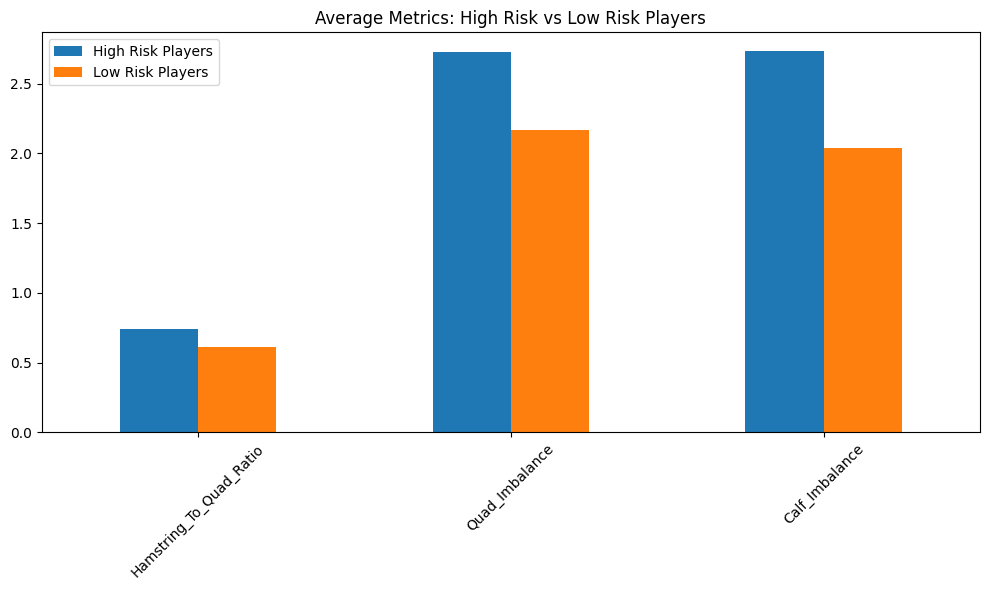


Summary of Risk Levels:
Risk_Level
Very Low     6
Low          0
Moderate     1
High         2
Very High    5
Name: count, dtype: int64

Average Risk Score by Position:
Position
Center     0.647088
Guard      0.478446
Forward    0.362084
Name: Risk_Score, dtype: float64

Key Risk Factors for High-Risk Players (Average Values):
      Hamstring_To_Quad_Ratio  Quad_Imbalance  Calf_Imbalance
mean                     0.74            2.73            2.73
std                      0.23            7.64            7.65
min                      0.45          -10.15          -10.18
max                      1.15           14.82           14.50


In [36]:
# Get predictions for all players
# First prepare all data
X_all = final_merged_df[selected_features].copy()
X_all['Position'] = le.transform(X_all['Position'])
X_all_scaled = scaler.transform(X_all)

# Get probabilities for all players
all_probabilities = calibrated_model.predict_proba(X_all_scaled)[:, 1]

# Create risk assessment dataframe
risk_assessment = pd.DataFrame({
    'Player_ID': final_merged_df['Player_ID'],
    'Name': final_merged_df['Name'],
    'Position': final_merged_df['Position'],
    'Risk_Score': all_probabilities,
    'High_Risk': all_probabilities >= optimal_threshold
})

# Add risk levels
risk_assessment['Risk_Level'] = pd.cut(
    risk_assessment['Risk_Score'],
    bins=[0, 0.2, 0.4, 0.6, 0.8, 1.0],
    labels=['Very Low', 'Low', 'Moderate', 'High', 'Very High']
)

# Add key metrics
risk_assessment['Hamstring_To_Quad_Ratio'] = final_merged_df['Hamstring_To_Quad_Ratio']
risk_assessment['Quad_Imbalance'] = final_merged_df['Quad_Imbalance_Percent']
risk_assessment['Calf_Imbalance'] = final_merged_df['Calf_Imbalance_Percent']

# Get the latest record for each player
latest_assessment = risk_assessment.sort_values('Risk_Score', ascending=False).drop_duplicates('Player_ID')

# Display top 20 highest risk players
print("\nTop 20 Players at Highest Risk:")
print(latest_assessment.nlargest(20, 'Risk_Score')[
    ['Name', 'Position', 'Risk_Score', 'Risk_Level', 
     'Hamstring_To_Quad_Ratio', 'Quad_Imbalance', 'Calf_Imbalance']
].to_string())

# Risk distribution by position
print("\nRisk Level Distribution by Position:")
position_risk = pd.crosstab(latest_assessment['Position'], latest_assessment['Risk_Level'])
print(position_risk)

# Visualize risk distribution
plt.figure(figsize=(12, 6))
sns.boxplot(data=latest_assessment, x='Position', y='Risk_Score')
plt.title('Risk Score Distribution by Position')
plt.ylabel('Risk Score')
plt.show()

# Plot top risk factors for high-risk players
high_risk_players = latest_assessment[latest_assessment['Risk_Score'] >= optimal_threshold]

plt.figure(figsize=(12, 6))
metrics = ['Hamstring_To_Quad_Ratio', 'Quad_Imbalance', 'Calf_Imbalance']
high_risk_metrics = high_risk_players[metrics].mean()
low_risk_metrics = latest_assessment[latest_assessment['Risk_Score'] < optimal_threshold][metrics].mean()

comparison_df = pd.DataFrame({
    'High Risk Players': high_risk_metrics,
    'Low Risk Players': low_risk_metrics
})

comparison_df.plot(kind='bar', figsize=(10, 6))
plt.title('Average Metrics: High Risk vs Low Risk Players')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Export high-risk players to CSV
high_risk_players.to_csv('high_risk_players.csv', index=False)

# Summary statistics
print("\nSummary of Risk Levels:")
print(latest_assessment['Risk_Level'].value_counts().sort_index())

print("\nAverage Risk Score by Position:")
print(latest_assessment.groupby('Position')['Risk_Score'].mean().sort_values(ascending=False))

# Identify risk factors contributing to high risk
print("\nKey Risk Factors for High-Risk Players (Average Values):")
risk_factors = ['Hamstring_To_Quad_Ratio', 'Quad_Imbalance', 'Calf_Imbalance']
print(high_risk_players[risk_factors].agg(['mean', 'std', 'min', 'max']).round(2))